In [1]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Your credentials
username = "soundDev"
password = "e1kemyOwhAYXNidM"
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"
database_name = "checkoutETL"
collection_name = "transactions"

# URL encode username and password in case of special chars
username = urllib.parse.quote_plus(username)
password = urllib.parse.quote_plus(password)

# Build the MongoDB connection string (note: mongodb:// not mongodb+srv://)
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/{database_name}"
    "?ssl=true&authSource=admin"
)

# Connect to MongoDB
client = MongoClient(mongo_uri)

# Select DB and collection
db = client[database_name]
collection = db[collection_name]

# Load data into DataFrame (limit to 1000 documents to avoid overload)
df = pd.DataFrame(list(collection.find()))

# Show first rows
print(df.head())


                        _id  transactionId 3DTxnResult  __v achBankName  \
0  6816c18f10f783ceceb640b1         438521       false    0        None   
1  6816c18f10f783ceceb640b9         438533       false    0        None   
2  6816c18f10f783ceceb640bb         438535       false    0        None   
3  6816c18f10f783ceceb640bc         438536       false    0        None   
4  6816c18f10f783ceceb640bd         438537       false    0        None   

   actualOrderId affId authCode avsResponse  billingCycleNumber  ...  \
0         292147  None     None        None                 3.0  ...   
1         292134  None     None        None                 1.0  ...   
2         292138  None     None        None                 1.0  ...   
3         292138  None     None        None                 1.0  ...   
4         292138  None     None        None                 1.0  ...   

  sourceValue2 sourceValue3 sourceValue4 sourceValue5  state  surcharge  \
0         None         None         None 

In [2]:
df.columns


Index(['_id', 'transactionId', '3DTxnResult', '__v', 'achBankName',
       'actualOrderId', 'affId', 'authCode', 'avsResponse',
       'billingCycleNumber', 'campaignCategoryName', 'campaignId',
       'campaignName', 'cardBin', 'cardIsDebit', 'cardIsPrepaid', 'cardLast4',
       'cardType', 'chargebackAmount', 'chargebackDate', 'chargebackNote',
       'chargebackReasonCode', 'city', 'clientOrderId', 'clientTxnId',
       'country', 'currencyCode', 'currencySymbol', 'custom1', 'custom2',
       'custom3', 'custom4', 'custom5', 'customerId', 'cvvResponse',
       'dateCreated', 'dateUpdated', 'funnelReferenceId', 'ipAddress',
       'isChargedback', 'items', 'merchant', 'merchantDescriptor',
       'merchantId', 'merchantTxnId', 'midNumber', 'orderAgentName', 'orderId',
       'orderType', 'parentTxnId', 'paySource', 'paySourceId', 'postalCode',
       'recycleNumber', 'refundReason', 'responseText', 'responseType',
       'sourceTitle', 'sourceValue1', 'sourceValue2', 'sourceValue3',


In [4]:
# Create a new column for CIT/MIT/Ignore
def classify_transaction_type(bcn):
    if bcn == 1:
        return 'CIT'
    elif bcn > 1:
        return 'MIT'
    elif bcn == 0:
        return 'Ignore'
    else:
        return None

df['transaction_type'] = df['billingCycleNumber'].apply(classify_transaction_type)


In [5]:
df['transaction_type']

0        MIT
1        CIT
2        CIT
3        CIT
4        CIT
        ... 
34227    CIT
34228    CIT
34229    CIT
34230    CIT
34231    CIT
Name: transaction_type, Length: 34232, dtype: object

In [6]:
cit_df = df[df['transaction_type'] == 'CIT'].copy()

In [11]:
top_campaigns = (
    cit_df['campaignName']
    .value_counts()
    .nlargest(10)
    .index
)

top_df = cit_df[cit_df['campaignName'].isin(top_campaigns)].copy()

top_df['responseType'] = top_df['responseType'].str.lower().str.strip()


In [12]:
top_df.loc[:, 'responseType'] = top_df['responseType'].str.lower().str.strip()


In [14]:
# Group by campaign + gateway + response type
agg = (
    top_df.groupby(['campaignName', 'merchant', 'responseType'])
    .size()
    .unstack(fill_value=0)  # Converts response types into columns
    .reset_index()
)

# Ensure 'success' column exists (if no 'success', fill with 0)
if 'success' not in agg.columns:
    agg['success'] = 0

# Compute total transactions across all response types
response_cols = [col for col in agg.columns if col not in ['campaignName', 'merchant']]
agg['total_txns'] = agg[response_cols].sum(axis=1)

# Compute approval rate
agg['approval_rate'] = agg['success'] / agg['total_txns']



In [15]:
agg.sort_values(by='approval_rate', ascending=False).head(10)


responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
28,MozzGuard,Stripe (Josh),0,0,0,2,2,1.000000
51,OptiFuel,Phoenix (NMI),0,0,0,19,19,1.000000
48,OptiFuel,NMI (EMS),0,0,0,8,8,1.000000
10,BTE Hearing CIC Pro (Native) Original,Stripe (Josh),0,0,0,7,7,1.000000
22,MozzGuard,NMI (EMS),0,0,0,2,2,1.000000
2,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
41,MozzGuard Purple - DE,Paypal US,0,0,7,533,540,0.987037
16,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
50,OptiFuel,Paypal US,0,0,33,1367,1400,0.976429
38,MozzGuard - UK,Paypal US,0,0,8,310,318,0.974843


In [16]:
# Filter combinations where total_txns > 50
filtered_agg = agg[agg['total_txns'] > 50].copy()

# Optional: sort by approval rate to review top entries
filtered_agg = filtered_agg.sort_values(by='approval_rate', ascending=False)


In [17]:
filtered_agg.head(20)


responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
2,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
41,MozzGuard Purple - DE,Paypal US,0,0,7,533,540,0.987037
16,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
50,OptiFuel,Paypal US,0,0,33,1367,1400,0.976429
38,MozzGuard - UK,Paypal US,0,0,8,310,318,0.974843
24,MozzGuard,Paypal US,0,0,11,404,415,0.973494
7,BTE Hearing CIC Pro (Native) Original,Paypal US,0,0,14,451,465,0.969892
33,MozzGuard - CA,Paypal US,0,0,31,808,839,0.963051
45,MozzGuard Purple - ES,Paypal US,0,0,9,230,239,0.962343
15,Blaze Buddy - AU,Paypal US,0,0,9,197,206,0.956311


In [18]:
# Get top 3 gateways by approval rate per campaign
top_gateways_per_campaign = (
    filtered_agg.groupby('campaignName', group_keys=False)
    .apply(lambda grp: grp.nlargest(3, 'approval_rate'))
    .reset_index(drop=True)
)


In [19]:
top_gateways_per_campaign.head(10)


responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
0,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
1,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,12,0,42,56,110,0.509091
2,BTE Hearing CIC Pro (Native) - UK,Adyen US,21,0,536,535,1092,0.489927
3,BTE Hearing CIC Pro (Native) Original,Paypal US,0,0,14,451,465,0.969892
4,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),69,0,2,737,808,0.912129
5,BTE Hearing CIC Pro (Native) Original,Seamless Chex (Auth.net),8,0,0,79,87,0.908046
6,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
7,Blaze Buddy - AU,Paypal US,0,0,9,197,206,0.956311
8,Blaze Buddy - AU,Payarc Josh (NMI),15,0,24,54,93,0.580645
9,MozzGuard,Paypal US,0,0,11,404,415,0.973494


In [20]:
# Normalize approval rate into percentage share per campaign//// routing adds up to 100% for each campaign across its top-performing gateways
def compute_gateway_split(df):
    total = df['approval_rate'].sum()
    df['recommended_split_percent'] = round((df['approval_rate'] / total) * 100, 2)
    return df

top_gateways_per_campaign = (
    top_gateways_per_campaign
    .groupby('campaignName', group_keys=False)
    .apply(compute_gateway_split)
)


In [21]:
top_gateways_per_campaign[['campaignName', 'merchant', 'approval_rate', 'recommended_split_percent']]


responseType,campaignName,merchant,approval_rate,recommended_split_percent
0,BTE Hearing CIC Pro (Native) - UK,Paypal US,0.992410,49.83
1,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,0.509091,25.56
2,BTE Hearing CIC Pro (Native) - UK,Adyen US,0.489927,24.60
3,BTE Hearing CIC Pro (Native) Original,Paypal US,0.969892,34.76
4,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),0.912129,32.69
5,BTE Hearing CIC Pro (Native) Original,Seamless Chex (Auth.net),0.908046,32.55
6,Blaze Buddy - AU,Paypal USD (Josh),0.984848,39.05
7,Blaze Buddy - AU,Paypal US,0.956311,37.92
8,Blaze Buddy - AU,Payarc Josh (NMI),0.580645,23.02
9,MozzGuard,Paypal US,0.973494,41.88


In [22]:
original_output = top_gateways_per_campaign.copy()

In [23]:
# Define international suffixes
intl_suffixes = [' - AU', ' - FR', ' - DE', ' - UK']

# Function to flag international campaigns
def is_international(name):
    return any(name.endswith(suffix) for suffix in intl_suffixes)

# Add flag
top_gateways_per_campaign['is_international'] = top_gateways_per_campaign['campaignName'].apply(is_international)

# Filter for valid gateways for international campaigns
valid_gateways = ['Adyen US', 'Adyen AU']
mask = ~top_gateways_per_campaign['is_international'] | top_gateways_per_campaign['merchant'].isin(valid_gateways)

# Keep filtered version
filtered_output = top_gateways_per_campaign[mask].copy()

# Optional: Re-normalize split %
filtered_output = (
    filtered_output
    .groupby('campaignName', group_keys=False)
    .apply(compute_gateway_split)  # Reuse from previous step
)


In [25]:
df['currencyCode'].unique()

array(['USD', 'GBP', 'AUD', 'EUR', 'CAD'], dtype=object)

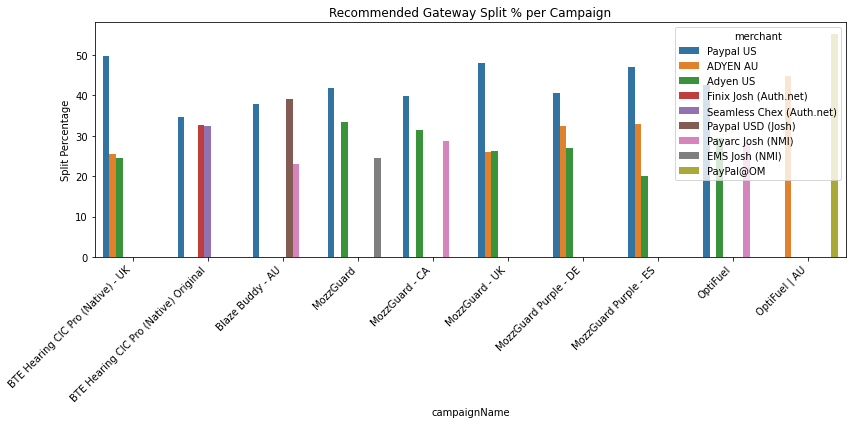

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_gateways_per_campaign,
    x="campaignName",
    y="recommended_split_percent",
    hue="merchant"
)
plt.title("Recommended Gateway Split % per Campaign")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Split Percentage")
plt.tight_layout()
plt.show()


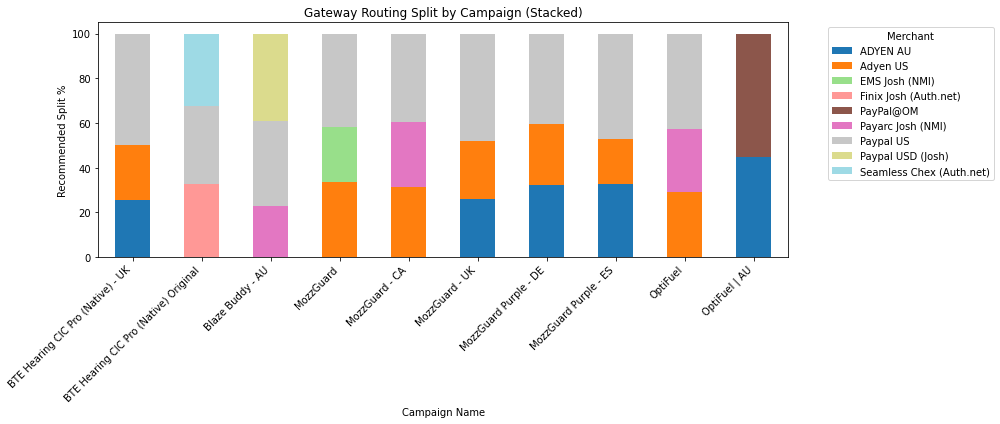

In [27]:
pivot_df = top_gateways_per_campaign.pivot_table(
    index='campaignName',
    columns='merchant',
    values='recommended_split_percent',
    fill_value=0
)

pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Gateway Routing Split by Campaign (Stacked)")
plt.ylabel("Recommended Split %")
plt.xlabel("Campaign Name")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Merchant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


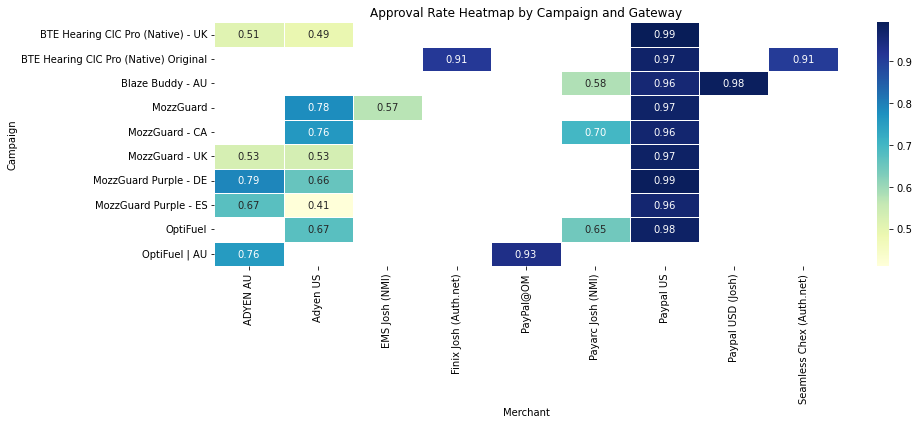

In [28]:
heatmap_data = top_gateways_per_campaign.pivot(
    index="campaignName",
    columns="merchant",
    values="approval_rate"
)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Approval Rate Heatmap by Campaign and Gateway")
plt.ylabel("Campaign")
plt.xlabel("Merchant")
plt.tight_layout()
plt.show()


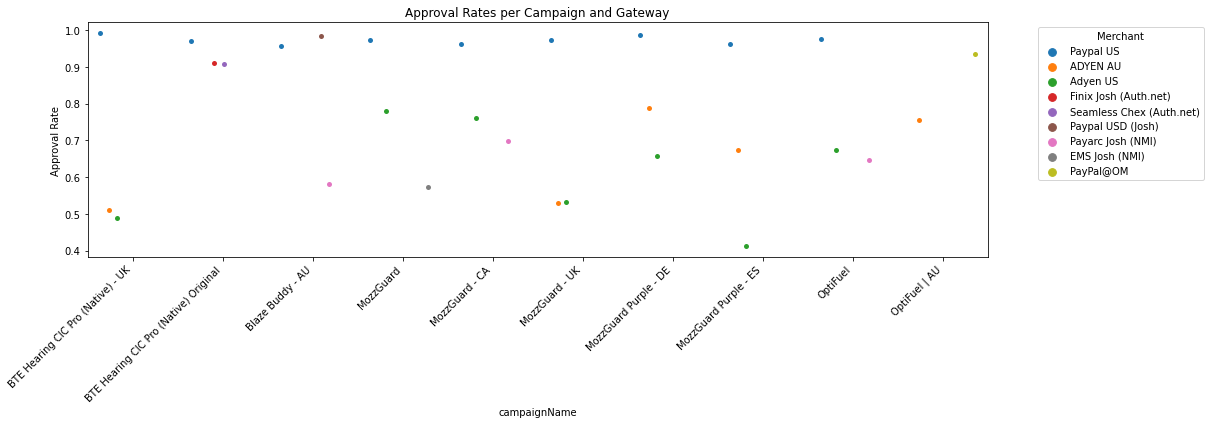

In [29]:
plt.figure(figsize=(14, 6))
sns.stripplot(
    data=top_gateways_per_campaign,
    x="campaignName",
    y="approval_rate",
    hue="merchant",
    dodge=True,
    jitter=True
)
plt.title("Approval Rates per Campaign and Gateway")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Approval Rate")
plt.tight_layout()
plt.legend(title="Merchant", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


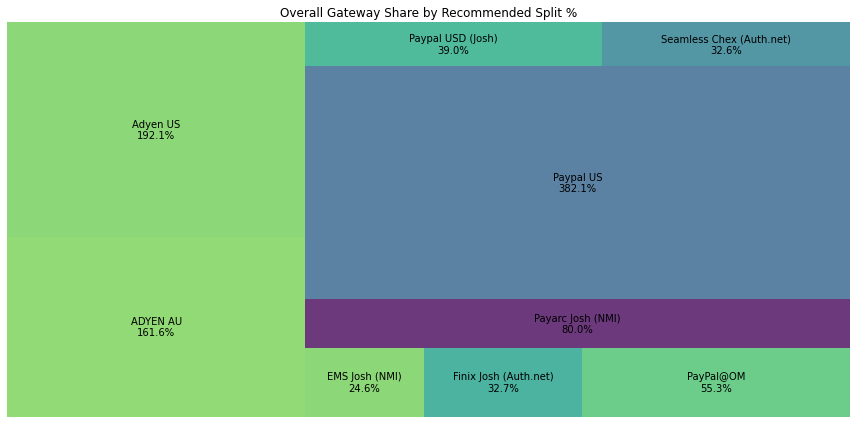

In [33]:
!  pip install squarify
import squarify

agg = top_gateways_per_campaign.groupby('merchant')['recommended_split_percent'].sum().reset_index()

plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=agg['recommended_split_percent'],
    label=agg['merchant'] + "\n" + agg['recommended_split_percent'].round(1).astype(str) + '%',
    alpha=0.8
)
plt.title("Overall Gateway Share by Recommended Split %")
plt.axis('off')
plt.tight_layout()
plt.show()
